In [111]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/home/artur/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [112]:
level = pd.read_csv('monthly-lake-erie-levels-1921-19.csv')
level['level'] = level['Monthly Lake Erie Levels 1921 ? 1970,']
level.level = level.level.fillna(method='ffill')
level = level.drop(600, axis=0)
level.index = pd.to_datetime(level.Month.values, format="%Y-%m")

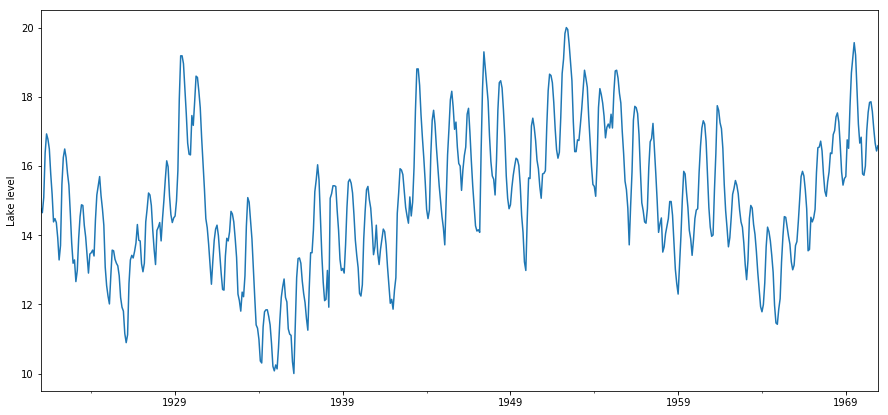

In [113]:
plt.figure(figsize(15,7))
level['Monthly Lake Erie Levels 1921 ? 1970,'].plot()
plt.ylabel('Lake level')
pylab.show()

Dickey–Fuller test: p=0.110912


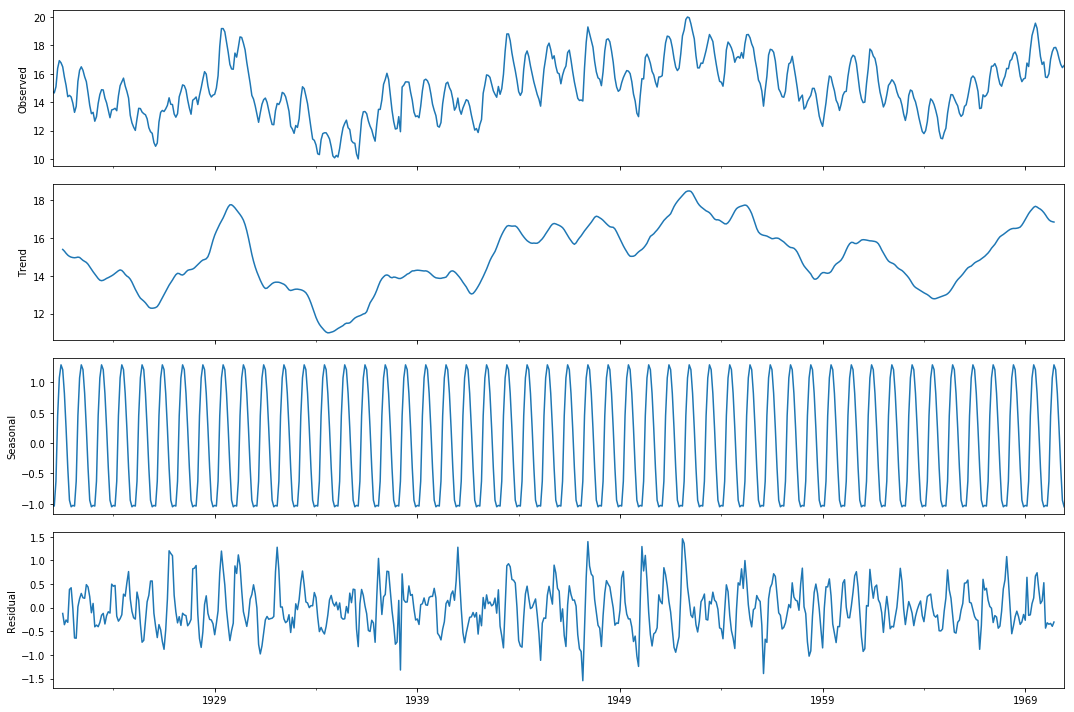

In [114]:
# stationarity test and STL-decomposition
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(level.level).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(level.level)[1])

Optimal lambda: 0.832856
Dickey–Fuller test: p=0.111674


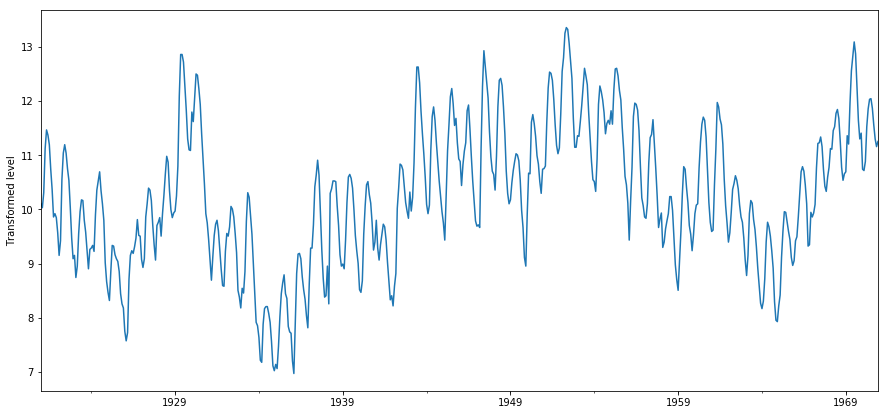

In [115]:
# Box-cox stabilization
level['level_box'], lmbda = stats.boxcox(level.level)
plt.figure(figsize(15,7))
level.level_box.plot()
plt.ylabel('Transformed level')
print("Optimal lambda: %f" % lmbda)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(level.level_box)[1])

Dickey–Fuller test: p=0.000001


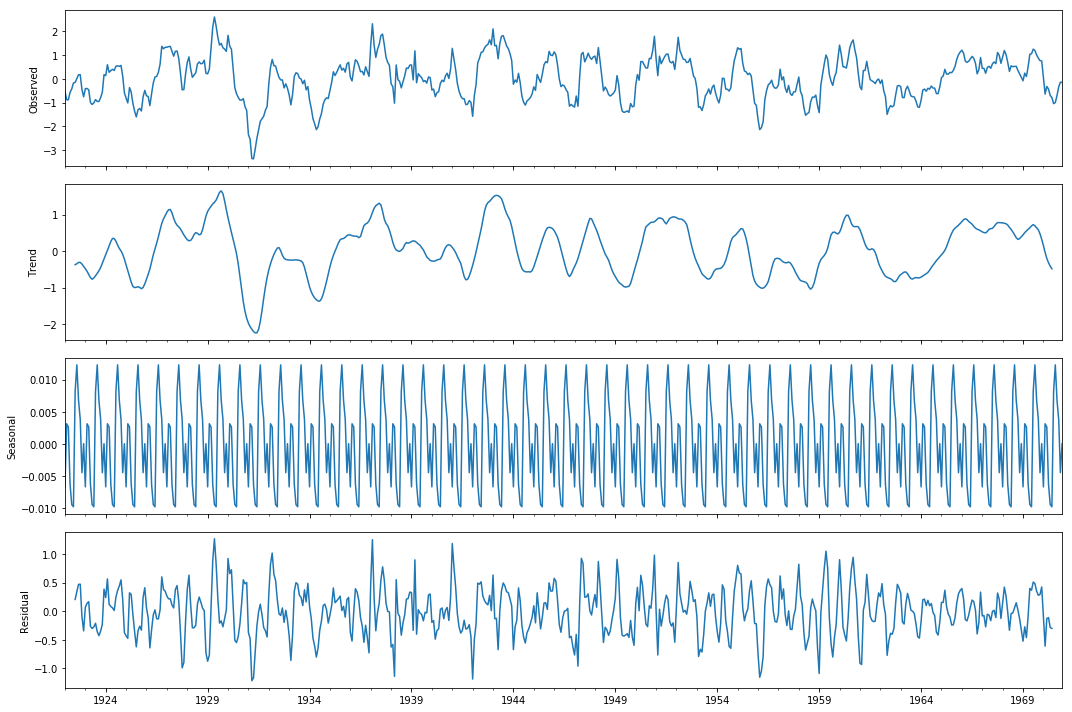

In [116]:
# seasonal diff
level['level_box_diff'] = level.level_box - level.level_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(level.level_box_diff[12:]).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(level.level_box_diff[12:])[1])

Dickey–Fuller test: p=0.000000


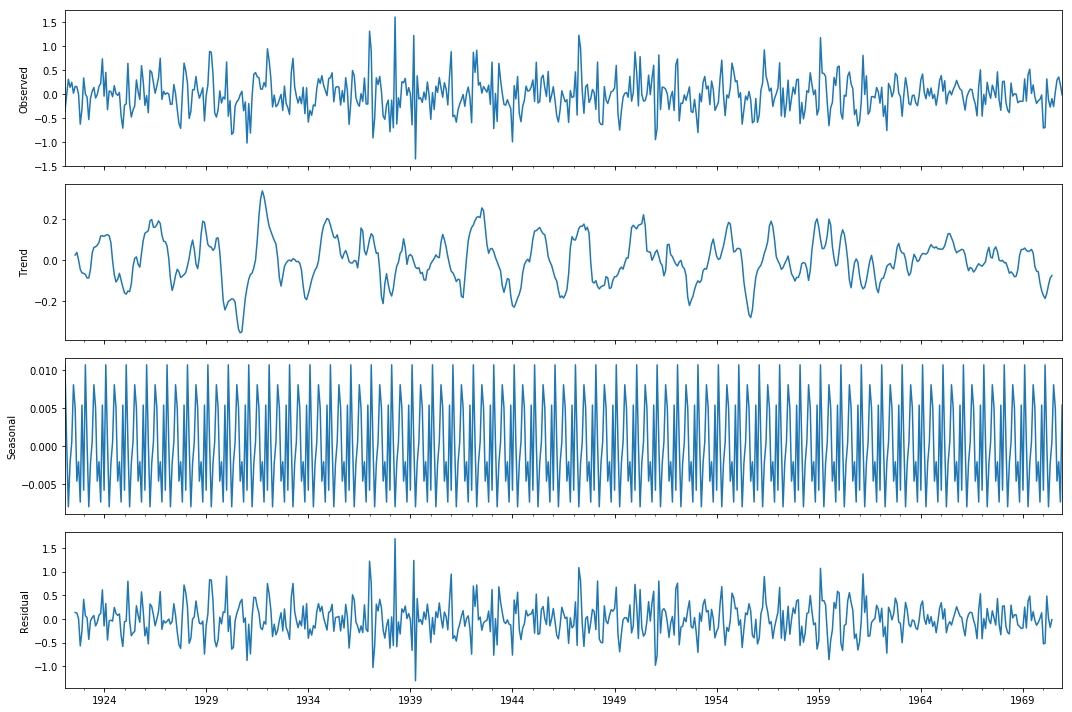

In [117]:
level['level_box_diff2'] = level.level_box_diff - level.level_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(level.level_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(level.level_box_diff2[13:])[1])

Dickey–Fuller test: p=0.000000


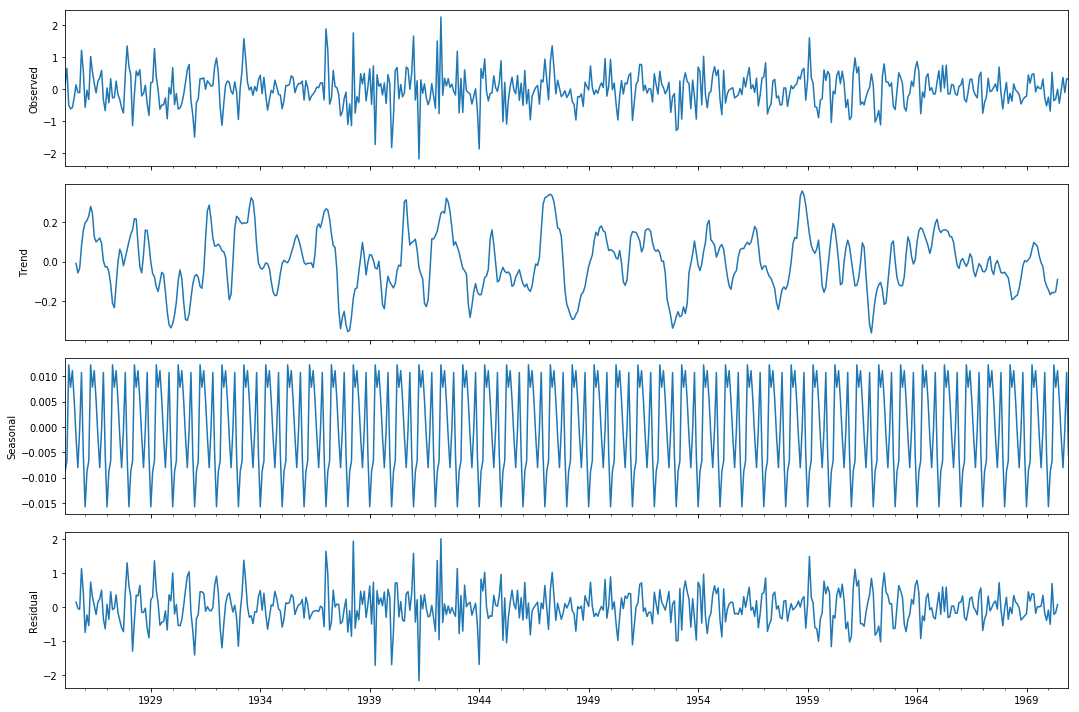

In [118]:
level['level_box_diff3'] = level.level_box_diff2 - level.level_box_diff2.shift(3*12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(level.level_box_diff3[13 + 3*12:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(level.level_box_diff3[13 + 3*12:])[1])

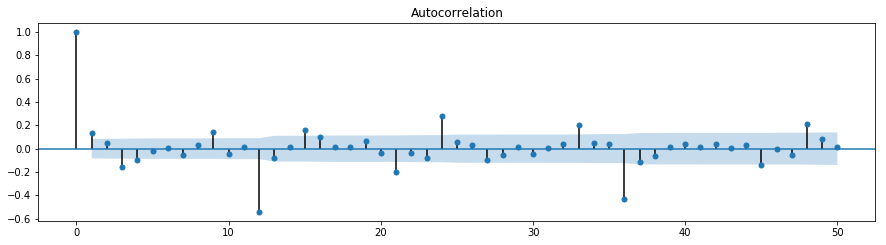

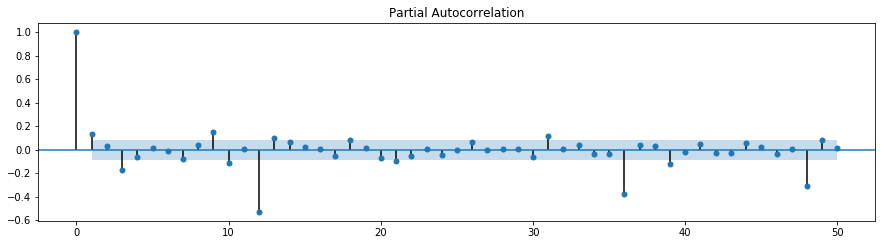

In [119]:
# ARIMA

plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(level.level_box_diff3[13 + 3*12:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(level.level_box_diff3[13 + 3*12:].values.squeeze(), lags=50, ax=ax)
pylab.show()

In [120]:
# q=2, Q=3, P=3 , p=9
ps = range(0, 10)
d=2
qs = range(0, 3)
Ps = range(0, 3)
D=2
Qs = range(0, 3)

In [121]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

270

In [122]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #we need try except because the model cannot be fitted for some combination of hyperparameter values
    try:
        model=sm.tsa.statespace.SARIMAX(level.level_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #models that we cannot fit
    except ValueError:
        print('wrong parameters: (', param[0], d, param[1], ') x (', param[2], D, param[3], ')')
        continue
    aic = model.aic
    #saving best model
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

wrong parameters: ( 0 2 0 ) x ( 0 2 0 )
wrong parameters: ( 0 2 0 ) x ( 0 2 1 )
wrong parameters: ( 0 2 0 ) x ( 1 2 2 )
wrong parameters: ( 0 2 0 ) x ( 2 2 2 )
wrong parameters: ( 0 2 1 ) x ( 0 2 1 )
wrong parameters: ( 0 2 1 ) x ( 1 2 2 )
wrong parameters: ( 0 2 1 ) x ( 2 2 2 )
wrong parameters: ( 0 2 2 ) x ( 0 2 1 )
wrong parameters: ( 0 2 2 ) x ( 1 2 2 )
wrong parameters: ( 0 2 2 ) x ( 2 2 2 )
wrong parameters: ( 1 2 0 ) x ( 0 2 1 )
wrong parameters: ( 1 2 0 ) x ( 1 2 2 )
wrong parameters: ( 1 2 0 ) x ( 2 2 2 )
wrong parameters: ( 1 2 1 ) x ( 0 2 1 )
wrong parameters: ( 1 2 1 ) x ( 1 2 2 )
wrong parameters: ( 1 2 1 ) x ( 2 2 2 )
wrong parameters: ( 1 2 2 ) x ( 0 2 1 )
wrong parameters: ( 1 2 2 ) x ( 1 2 2 )
wrong parameters: ( 1 2 2 ) x ( 2 2 2 )
wrong parameters: ( 2 2 0 ) x ( 0 2 1 )
wrong parameters: ( 2 2 0 ) x ( 1 2 2 )
wrong parameters: ( 2 2 0 ) x ( 2 2 2 )
wrong parameters: ( 2 2 1 ) x ( 0 2 0 )
wrong parameters: ( 2 2 1 ) x ( 0 2 1 )
wrong parameters: ( 2 2 1 ) x ( 0 2 2 )


In [123]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
58   (3, 1, 2, 1)  311.474956
70   (4, 1, 2, 1)  312.601393
88   (5, 1, 2, 1)  313.983445
28   (1, 1, 2, 1)  314.166509
106  (6, 1, 2, 1)  314.891578


In [124]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          level_box   No. Observations:                  600
Model:             SARIMAX(3, 2, 1)x(2, 2, 1, 12)   Log Likelihood                -147.737
Date:                            Sun, 30 Apr 2017   AIC                            311.475
Time:                                    18:34:00   BIC                            346.650
Sample:                                01-01-1921   HQIC                           325.168
                                     - 12-01-1970                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1888      0.033      5.741      0.000       0.124       0.253
ar.L2          0.0387      0.038   

Student's t-test: p=0.532825
Dickey–Fuller test: p=0.000000


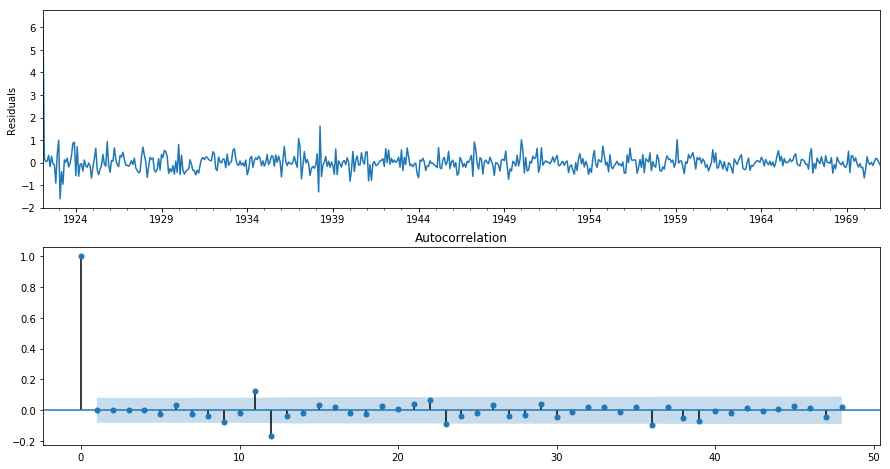

In [125]:
# residuals
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's t-test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

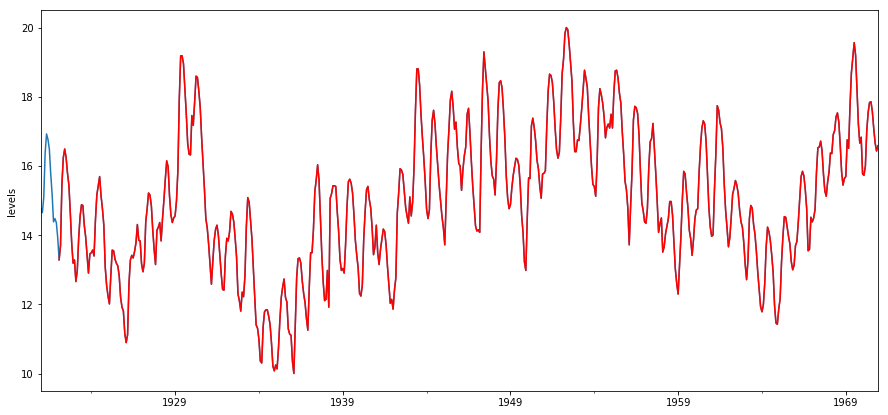

In [126]:
level['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
level.level.plot()
level.level[13:].plot(color='r')
plt.ylabel('levels')
pylab.show()

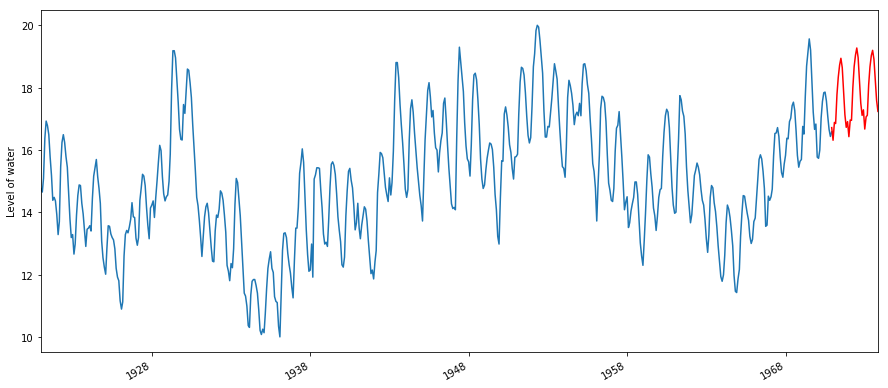

In [127]:
# forecast
level2 = level[['level']]
date_list = [datetime.datetime.strptime("1970-12-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= level2.columns)
level2 = pd.concat([level2, future])
level2['forecast'] = invboxcox(best_model.predict(start=599, end=636), lmbda)

plt.figure(figsize(15,7))
level2.level.plot()
level2.forecast.plot(color='r')
plt.ylabel('Level of water')
pylab.show()

(636, 2)